In [1]:
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os 
#import seaborn as sns
import warnings 
from tqdm.notebook import tqdm 
%matplotlib inline

In [2]:
BASE_DIR = 'C:\\Users\\micha\\GitRepos\\AgeRecognition(ML)\\UTKFace'
age_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

image_filenames[0]

'58_0_0_20170104212603957.jpg.chip.jpg'

In [3]:
for image in tqdm(image_filenames):
    image_path = os.path.join(BASE_DIR, image)
    img_components = image.split('_')

    if img_components[0] == '.ipynb':
        continue
    age_label = int(img_components[0])
    
    # Append the image_path, age_label, and gender_label
    age_labels.append(age_label)
    image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [4]:
print(f'Number of age_labels: {len(age_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 23708, Number of image_paths: 23708


In [5]:
import pandas as pd 
df = pd.DataFrame()
df['image_path'], df['age'] = image_paths, age_labels
df.head(5)

,image_path,age
0,C:\Users\micha\GitRepos\AgeRecognition(ML)\UTK...,58
1,C:\Users\micha\GitRepos\AgeRecognition(ML)\UTK...,54
2,C:\Users\micha\GitRepos\AgeRecognition(ML)\UTK...,75
3,C:\Users\micha\GitRepos\AgeRecognition(ML)\UTK...,80
4,C:\Users\micha\GitRepos\AgeRecognition(ML)\UTK...,30


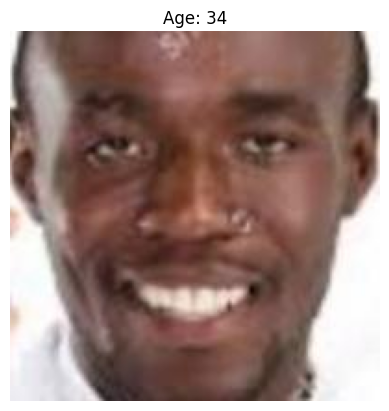

In [6]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age}')
plt.axis('off')
plt.imshow(IMG)

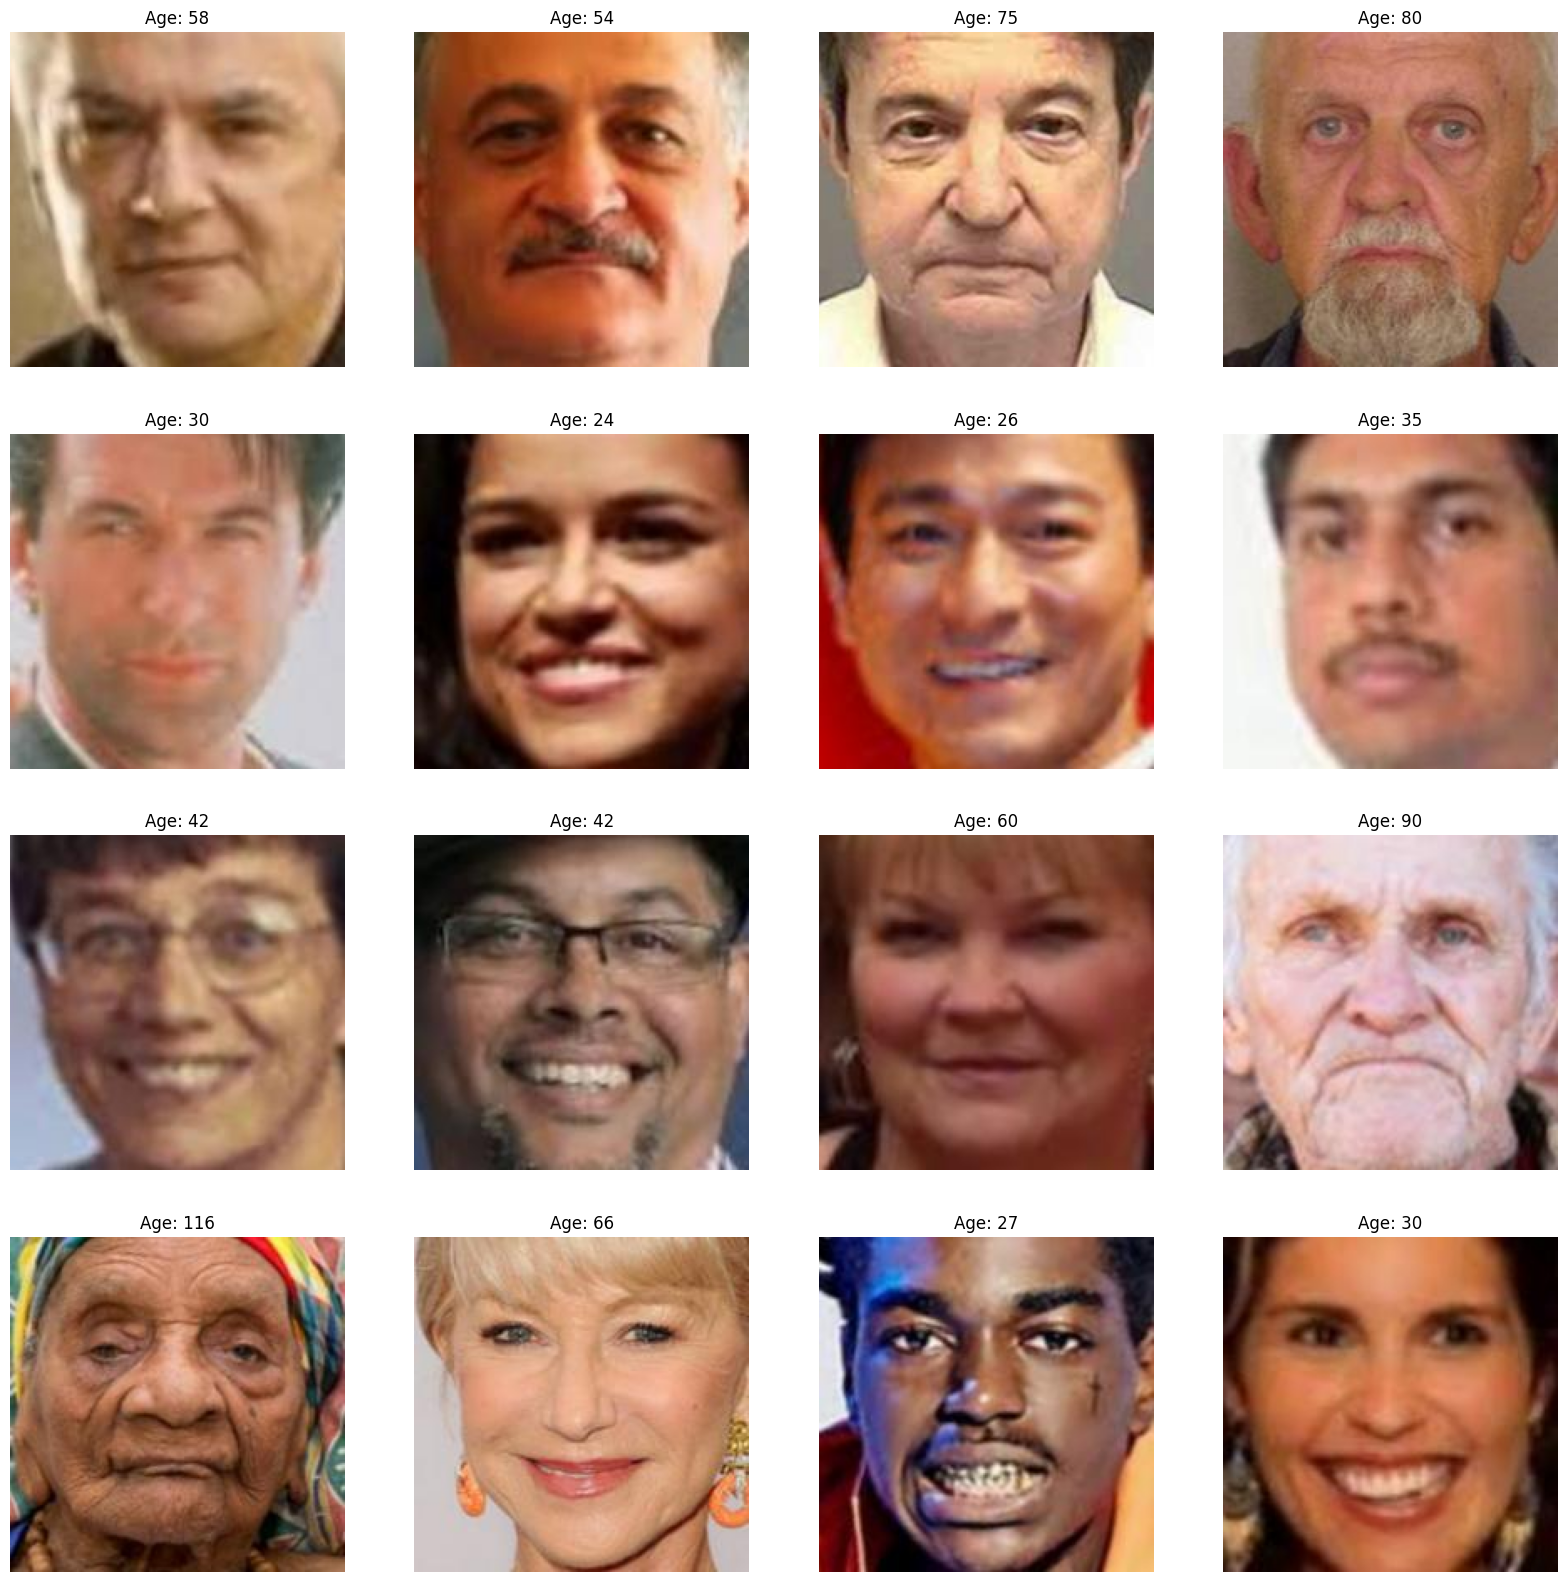

In [7]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age}')
    plt.imshow(img)

In [8]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image)
        img = img.resize((128, 128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 3)
    return features

In [9]:
X = extract_image_features(df['image_path'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [10]:
X.shape

(23708, 128, 128, 3)

In [11]:
X = X / 255.0

In [12]:
y_age = np.array(df['age'])

In [13]:
import keras

In [14]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [15]:
input_shape = (128, 128, 3)

In [16]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=input_shape, padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters=filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(1, activation="relu"))

In [17]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [21]:
history = model.fit(x=X, y=y_age,
                    batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
593/593 [==============================] - 902s 2s/step - loss: 46.3034 - accuracy: 0.0392 - val_loss: 86.1227 - val_accuracy: 0.0504
Epoch 2/10
593/593 [==============================] - 912s 2s/step - loss: 41.0797 - accuracy: 0.0362 - val_loss: 172.1145 - val_accuracy: 0.0441
Epoch 3/10
593/593 [==============================] - 903s 2s/step - loss: 36.8429 - accuracy: 0.0355 - val_loss: 102.4203 - val_accuracy: 0.0458
Epoch 4/10
593/593 [==============================] - 906s 2s/step - loss: 32.1884 - accuracy: 0.0369 - val_loss: 83.2615 - val_accuracy: 0.0481
Epoch 5/10
593/593 [==============================] - 899s 2s/step - loss: 29.4265 - accuracy: 0.0369 - val_loss: 101.1201 - val_accuracy: 0.0240
Epoch 6/10
593/593 [==============================] - 907s 2s/step - loss: 24.4777 - accuracy: 0.0383 - val_loss: 146.2246 - val_accuracy: 0.0496
Epoch 7/10
593/593 [==============================] - 900s 2s/step - loss: 23.9938 - accuracy: 0.0377 - val_loss: 207.9809 - v

In [22]:
from tensorflow.keras.models import load_model
model.save('ResNet_reg_20.keras')

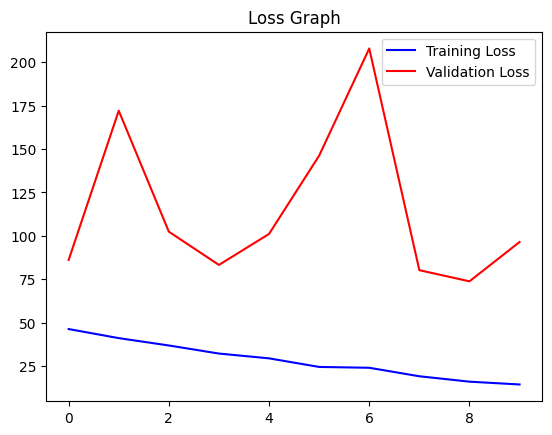

In [23]:
# plot results for age
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [27]:
model = load_model('ResNet_reg.keras')

TypeError: Cannot deserialize object of type `ResidualUnit`. If `ResidualUnit` is a custom class, please register it using the `@keras.saving.register_keras_serializable()` decorator.

In [24]:
def get_image_features(image):
  img = load_img(image)
  img = img.resize((128, 128), Image.LANCZOS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 3)
  img = img / 255.0
  return img

In [25]:
img_to_test = 'FaceRecognition/CamData/data/test/images/00bf6f4c-7fdd-11ee-9103-ec773ba9cb5a.jpg'
features = get_image_features(img_to_test)
pred = model.predict(features)

pred[0].round(2)

1/1 [==============================] - 1s 622ms/step


array([62.31], dtype=float32)

In [22]:
def get_result(model, image):
    features = get_image_features(img_to_test)
    pred = model.predict(features)
    max = pred[0][0]
    result = 0
    i = 0
    for p in pred[0]:
        if p > max:
            max = p
            result = i
        i = i+1
    return result

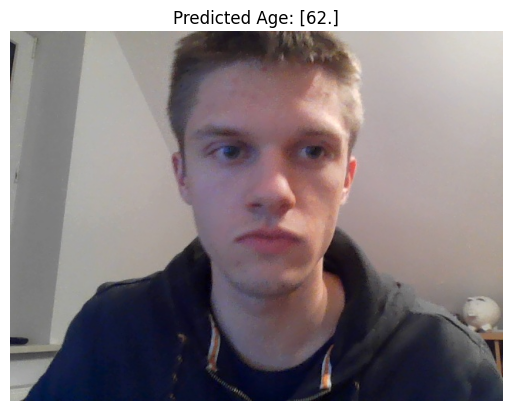

In [26]:
#age = get_result(model, img_to_test)
age = pred[0].round()

plt.title(f'Predicted Age: {age}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))